In [1]:
import pandas as pd
import numpy as np
from ngcc_ml import data_tools
from itertools import product

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# ML
import tensorflow as tf

import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

In [2]:
def process_data(df_in, oneHotCols=[], scaledCols=[]):
    df = df_in.copy()
    scaler = StandardScaler()
    oneHotEncoder = OneHotEncoder(categories = "auto", sparse = False)
    if scaledCols != []:
        df[scaledCols] = scaler.fit_transform(df[scaledCols])
    #if oneHotCols != []:
    #    df[encoded_columns] = oneHotEncoder.fit_transform(alldata[oneHotCols])
    return df


def group_split_evaluate(model, df_xy, feature_cols, target_col="BindingEnergy", n_splits=10, group_col="catalyst_name"):
    all_scores, models = [], []
    split_groups = GroupShuffleSplit(test_size=1.0/n_splits, n_splits=n_splits, random_state = 7).split(df_xy, groups=df_xy[group_col])
    model.save_weights("initial_weights.h5")
    for train_inds, test_inds in split_groups:
        model.load_weights("initial_weights.h5")
        train = df_xy.iloc[train_inds]
        test = df_xy.iloc[test_inds]
        X_train_group = train[feature_cols]
        X_test_group = test[feature_cols]
        y_train_group = train[target_col]
        y_test_group = test[target_col]
        model.fit(X_train_group, y_train_group, epochs=150, batch_size=16)
        mae = model.evaluate(X_test_group, y_test_group)
        all_scores.append(mae)
        models.append(model)
        print('MAE on test set: {:.2f}'.format(mae))
    print("mean:", np.mean(all_scores))
    return all_scores


def create_ffnn_regression(inp_dim, all_lsize, l2_reg=0.0001, drop_val = 0.1):
    model = Sequential()
    model.add(Dense(all_lsize[0], input_dim=inp_dim, activation="relu", kernel_regularizer=keras.regularizers.l2(l2_reg)))
    model.add(Dropout(drop_val))
    for lsize in all_lsize[1:]:
        model.add(Dense(lsize, activation='relu', kernel_initializer="normal", kernel_regularizer=regularizers.l2(l2_reg)))
        model.add(Dropout(drop_val))
    model.add(Dense(1, kernel_initializer="normal"))
    return model


def sample_list(inlist):
    return inlist[np.random.randint(len(inlist))]


def sample_nested_list(inlist):
    sampled = []
    for sublist in inlist:
        sampled.append(sample_list(sublist))
    return sampled


def hyperparam_sample(df_xy, feature_cols, lsize_opts, l2_reg_opts, drop_val_opts, n_splits=5, hyperparam_samples=6):
    
    lsize_list, l2_reg_list, drop_val_list, group_scores_list = [], [], [], []
    for i in range(hyperparam_samples):
        lsize_sample = sample_nested_list(lsize_opts)
        l2_reg_sample = sample_list(l2_reg_opts)
        drop_val_sample = sample_list(drop_val_opts)   
        model = create_ffnn_regression(len(feature_cols), lsize_sample, l2_reg_sample, drop_val_sample)
        model.compile(loss="mean_absolute_error", optimizer="adam")
        group_scores = group_split_evaluate(model, df_xy, feature_cols, n_splits=n_splits)

        lsize_list.append(lsize_sample)
        l2_reg_list.append(l2_reg_sample)
        drop_val_list.append(drop_val_sample)
        group_scores_list.append(group_scores)
    
    df_results = pd.DataFrame({"lsize":lsize_list, "l2_reg":l2_reg_list, "drop_val":drop_val_list, "scores":group_scores_list})
    return df_results


def hyperparam_grid(df_xy, feature_cols, lsize_opts, l2_reg, drop_val, target_col="BindingEnergy", n_splits=5):
    
    lsize_list, l2_reg_list, drop_val_list, group_scores_list = [], [], [], []
    for layer in product(*lsize_opts):
        lsize = sample_nested_list(lsize_opts)   
        model = create_ffnn_regression(len(feature_cols), lsize, l2_reg, drop_val)
        model.compile(loss="mean_absolute_error", optimizer="adam")
        group_scores = group_split_evaluate(model, df_xy, feature_cols, target_col=target_col, n_splits=n_splits)

        lsize_list.append(lsize)
        l2_reg_list.append(l2_reg)
        drop_val_list.append(drop_val)
        group_scores_list.append(group_scores)
    
    df_results = pd.DataFrame({"lsize":lsize_list, "l2_reg":l2_reg_list, "drop_val":drop_val_list, "scores":group_scores_list})
    return df_results

In [3]:
df = pd.read_csv("/home/nricke/work/ngcc_ml/DidItBindv5.csv", index_col=0)
df.rename(columns={"Catalyst Name":"catalyst_name"}, inplace=True)
df["Doesitbind"] = df["Doesitbind"].astype("int")
df = df[df["Doesitbind"] == 1]

In [4]:
df.columns

Index(['Atom Number', 'catalyst_name', 'CatalystO2File', 'Element',
       'SpinDensity', 'ChElPGPositiveCharge', 'ChElPGNeutralCharge',
       'ChargeDifference', 'Doesitbind', 'BondLength', 'IonizedFreeEnergy',
       'IonizationEnergy', 'BindingEnergy', 'NeutralFreeEnergy', 'OrthoOrPara',
       'Meta', 'FartherThanPara', 'DistanceToN', 'AverageBondLength',
       'BondLengthRange', 'NumberOfHydrogens', 'AromaticSize', 'IsInRingSize6',
       'IsInRingSize5', 'NeighborSpinDensity', 'NeighborChElPGCharge',
       'NeighborChargeDifference', 'AromaticExtent', 'RingEdge',
       'NumNitrogens', 'NumHeteroatoms', 'ring_nitrogens',
       'atom_plane_deviation', 'ring_plane_deviation', 'charge'],
      dtype='object')

In [5]:
feature_cols = {"SpinDensity", "ChElPGNeutralCharge", "ChargeDifference", "IonizationEnergy", "OrthoOrPara", "Meta", "FartherThanPara", "DistanceToN", "NumberOfHydrogens", "IsInRingSize6", "IsInRingSize5", "NeighborSpinDensity", 'NeighborChElPGCharge', 'NeighborChargeDifference', "AromaticExtent", "RingEdge", "NumNitrogens", "NumHeteroatoms", "charge", "atom_plane_deviation", "ring_plane_deviation", "ring_nitrogens"}
not_scaled_cols = {"OrthoOrPara", "Meta", "FartherThanPara", "NumberOfHydrogens", "IsInRingSize6", "IsInRingSize5", "RingEdge", "NumNitrogens", "NumHeteroatoms", "ring_nitrogens", "charge"}
df_scale = process_data(df, scaledCols=list(feature_cols - not_scaled_cols))
X = df_scale[feature_cols]
y = df_scale["BindingEnergy"]

In [113]:
lsizes = [[128, 256], [128, 256], [64, 128], [16, 32], [8, 16]]
#lsizes = [[128], [256], [32], [16]]
l2_regs = 0.00001
drop_vals = 0.2
df_hypes_5 = hyperparam_grid(df_scale, feature_cols, lsizes, l2_regs, drop_vals)

Epoch 1/150
37/37 [==============================] - 0s 3ms/step - loss: 0.2916
Epoch 2/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1810
Epoch 3/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1546
Epoch 4/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1499
Epoch 5/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1504
Epoch 6/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1382
Epoch 7/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1361
Epoch 8/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1353
Epoch 9/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1182
Epoch 10/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1188
Epoch 11/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1164
Epoch 12/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1130
Epoch 13/150
37/37 [=================

36/36 [==============================] - 0s 3ms/step - loss: 0.0782
Epoch 52/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0695
Epoch 53/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0763
Epoch 54/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0763
Epoch 55/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0736
Epoch 56/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 57/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0755
Epoch 58/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0746
Epoch 59/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0733
Epoch 60/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 61/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0766
Epoch 62/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0703
Epoch 63/150
36/36 [=====================

36/36 [==============================] - 0s 3ms/step - loss: 0.0668
Epoch 102/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0669
Epoch 103/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0682
Epoch 104/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0664
Epoch 105/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0653
Epoch 106/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0705
Epoch 107/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0709
Epoch 108/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0680
Epoch 109/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0653
Epoch 110/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0646
Epoch 111/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0682
Epoch 112/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0695
Epoch 113/150
36/36 [=========

5/5 [==============================] - 0s 1ms/step - loss: 0.0943
MAE on test set: 0.09
Epoch 1/150
37/37 [==============================] - 0s 3ms/step - loss: 0.2711
Epoch 2/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1623
Epoch 3/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1646
Epoch 4/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1373
Epoch 5/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1295
Epoch 6/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1412
Epoch 7/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1272
Epoch 8/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1212
Epoch 9/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1173
Epoch 10/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1161
Epoch 11/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1163
Epoch 12/150
37/37 [==========

37/37 [==============================] - 0s 3ms/step - loss: 0.0819
Epoch 50/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0843
Epoch 51/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0840
Epoch 52/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0791
Epoch 53/150
37/37 [==============================] - 0s 4ms/step - loss: 0.0838
Epoch 54/150
37/37 [==============================] - 0s 4ms/step - loss: 0.0828
Epoch 55/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0807
Epoch 56/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0843
Epoch 57/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0795
Epoch 58/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0821
Epoch 59/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0846
Epoch 60/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0763
Epoch 61/150
37/37 [=====================

36/36 [==============================] - 0s 3ms/step - loss: 0.0696
Epoch 100/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0704
Epoch 101/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0709
Epoch 102/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0685
Epoch 103/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0688
Epoch 104/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 105/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0693
Epoch 106/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0639
Epoch 107/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0722
Epoch 108/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0661
Epoch 109/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0678
Epoch 110/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0627
Epoch 111/150
36/36 [=========

36/36 [==============================] - 0s 3ms/step - loss: 0.0621
Epoch 149/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0573
Epoch 150/150
6/6 [==============================] - 0s 1ms/step - loss: 0.0687
MAE on test set: 0.07
Epoch 1/150
37/37 [==============================] - 0s 3ms/step - loss: 0.3586
Epoch 2/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1794
Epoch 3/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1571
Epoch 4/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1375
Epoch 5/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1244
Epoch 6/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1278
Epoch 7/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1198
Epoch 8/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1123
Epoch 9/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1109
Epoch 10/150
37/37 [========

37/37 [==============================] - 0s 3ms/step - loss: 0.0816
Epoch 48/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0811
Epoch 49/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0798
Epoch 50/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0791
Epoch 51/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0784
Epoch 52/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0790
Epoch 53/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0769
Epoch 54/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0776
Epoch 55/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0763
Epoch 56/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0745
Epoch 57/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0766
Epoch 58/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0720
Epoch 59/150
37/37 [=====================

Epoch 97/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0704
Epoch 98/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0740
Epoch 99/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0765
Epoch 100/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0747
Epoch 101/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0723
Epoch 102/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0752
Epoch 103/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0757
Epoch 104/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0698
Epoch 105/150
37/37 [==============================] - 0s 4ms/step - loss: 0.0761
Epoch 106/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0739
Epoch 107/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0723
Epoch 108/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0705
Epoch 109/150
37/37

36/36 [==============================] - 0s 3ms/step - loss: 0.0592
Epoch 147/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0581
Epoch 148/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0593
Epoch 149/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0613
Epoch 150/150
6/6 [==============================] - 0s 2ms/step - loss: 0.0844
MAE on test set: 0.08
Epoch 1/150
36/36 [==============================] - 0s 3ms/step - loss: 0.3247
Epoch 2/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1687
Epoch 3/150
36/36 [==============================] - 0s 4ms/step - loss: 0.1508
Epoch 4/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1383
Epoch 5/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1353
Epoch 6/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1281
Epoch 7/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1228
Epoch 8/150
36/36 [=====

37/37 [==============================] - 0s 3ms/step - loss: 0.0714
Epoch 46/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0697
Epoch 47/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0678
Epoch 48/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0687
Epoch 49/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0705
Epoch 50/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0694
Epoch 51/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0695
Epoch 52/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0707
Epoch 53/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0703
Epoch 54/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0663
Epoch 55/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0662
Epoch 56/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0624
Epoch 57/150
37/37 [=====================

37/37 [==============================] - 0s 3ms/step - loss: 0.0632
Epoch 96/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0619
Epoch 97/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0630
Epoch 98/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0626
Epoch 99/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0659
Epoch 100/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0642
Epoch 101/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0619
Epoch 102/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0645
Epoch 103/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0625
Epoch 104/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0585
Epoch 105/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0591
Epoch 106/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0609
Epoch 107/150
37/37 [=============

37/37 [==============================] - 0s 3ms/step - loss: 0.0758
Epoch 145/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0737
Epoch 146/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0708
Epoch 147/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0707
Epoch 148/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0723
Epoch 149/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 150/150
5/5 [==============================] - 0s 1ms/step - loss: 0.0973
MAE on test set: 0.10
Epoch 1/150
36/36 [==============================] - 0s 3ms/step - loss: 0.3736
Epoch 2/150
36/36 [==============================] - 0s 3ms/step - loss: 0.2091
Epoch 3/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1576
Epoch 4/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1483
Epoch 5/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1331
Epoch 6/150
36/36 [=

36/36 [==============================] - 0s 4ms/step - loss: 0.0863
Epoch 44/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0832
Epoch 45/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0904
Epoch 46/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0904
Epoch 47/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0844
Epoch 48/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0878
Epoch 49/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0827
Epoch 50/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0808
Epoch 51/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0825
Epoch 52/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0813
Epoch 53/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0819
Epoch 54/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0825
Epoch 55/150
36/36 [=====================

37/37 [==============================] - 0s 3ms/step - loss: 0.0661
Epoch 94/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0652
Epoch 95/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0660
Epoch 96/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0649
Epoch 97/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0667
Epoch 98/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0688
Epoch 99/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0617
Epoch 100/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0642
Epoch 101/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0651
Epoch 102/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0646
Epoch 103/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0687
Epoch 104/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0668
Epoch 105/150
37/37 [===============

37/37 [==============================] - 0s 3ms/step - loss: 0.0615
Epoch 143/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0613
Epoch 144/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0612
Epoch 145/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0615
Epoch 146/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0620
Epoch 147/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0630
Epoch 148/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0603
Epoch 149/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0606
Epoch 150/150
5/5 [==============================] - 0s 2ms/step - loss: 0.0838
MAE on test set: 0.08
mean: 0.08740922510623932
Epoch 1/150
37/37 [==============================] - 0s 3ms/step - loss: 0.2975
Epoch 2/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1553
Epoch 3/150
37/37 [==============================] - 0s 3ms/step - los

36/36 [==============================] - 0s 3ms/step - loss: 0.0745
Epoch 41/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0762
Epoch 42/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0771
Epoch 43/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0765
Epoch 44/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0774
Epoch 45/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0736
Epoch 46/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0729
Epoch 47/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0781
Epoch 48/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0732
Epoch 49/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0778
Epoch 50/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0733
Epoch 51/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0735
Epoch 52/150
36/36 [=====================

36/36 [==============================] - 0s 3ms/step - loss: 0.0623
Epoch 91/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0624
Epoch 92/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0652
Epoch 93/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0607
Epoch 94/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0614
Epoch 95/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0657
Epoch 96/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0669
Epoch 97/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0667
Epoch 98/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0667
Epoch 99/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0637
Epoch 100/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0637
Epoch 101/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0647
Epoch 102/150
36/36 [==================

37/37 [==============================] - 0s 3ms/step - loss: 0.0586
Epoch 140/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0554
Epoch 141/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0563
Epoch 142/150
37/37 [==============================] - 0s 4ms/step - loss: 0.0578
Epoch 143/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0581
Epoch 144/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0575
Epoch 145/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0568
Epoch 146/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0533
Epoch 147/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0537
Epoch 148/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0572
Epoch 149/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0521
Epoch 150/150
5/5 [==============================] - 0s 1ms/step - loss: 0.0906
MAE on test set: 0.09
Epoch 1/15

37/37 [==============================] - 0s 4ms/step - loss: 0.0848
Epoch 39/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0875
Epoch 40/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0837
Epoch 41/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0838
Epoch 42/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0790
Epoch 43/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0756
Epoch 44/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0805
Epoch 45/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0867
Epoch 46/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0840
Epoch 47/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0750
Epoch 48/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0797
Epoch 49/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0795
Epoch 50/150
37/37 [=====================

36/36 [==============================] - 0s 3ms/step - loss: 0.0673
Epoch 89/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0756
Epoch 90/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0688
Epoch 91/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0730
Epoch 92/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0685
Epoch 93/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0691
Epoch 94/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0686
Epoch 95/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0736
Epoch 96/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0708
Epoch 97/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0729
Epoch 98/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0688
Epoch 99/150
36/36 [==============================] - 0s 4ms/step - loss: 0.0722
Epoch 100/150
36/36 [====================

36/36 [==============================] - 0s 3ms/step - loss: 0.0676
Epoch 138/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0701
Epoch 139/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0653
Epoch 140/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0682
Epoch 141/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0672
Epoch 142/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0643
Epoch 143/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0695
Epoch 144/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0670
Epoch 145/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0661
Epoch 146/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0652
Epoch 147/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0623
Epoch 148/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0683
Epoch 149/150
36/36 [=========

37/37 [==============================] - 0s 3ms/step - loss: 0.0810
Epoch 37/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0803
Epoch 38/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0779
Epoch 39/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0780
Epoch 40/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0778
Epoch 41/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0794
Epoch 42/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0785
Epoch 43/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0791
Epoch 44/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0775
Epoch 45/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0784
Epoch 46/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0781
Epoch 47/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0757
Epoch 48/150
37/37 [=====================

37/37 [==============================] - 0s 3ms/step - loss: 0.0707
Epoch 86/150
37/37 [==============================] - 0s 4ms/step - loss: 0.0655
Epoch 87/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0689
Epoch 88/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0667
Epoch 89/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0667
Epoch 90/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0729
Epoch 91/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0718
Epoch 92/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0720
Epoch 93/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0676
Epoch 94/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0659
Epoch 95/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0682
Epoch 96/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0653
Epoch 97/150
37/37 [=====================

36/36 [==============================] - 0s 3ms/step - loss: 0.0639
Epoch 135/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0649
Epoch 136/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0657
Epoch 137/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0608
Epoch 138/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0617
Epoch 139/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0653
Epoch 140/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0677
Epoch 141/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0637
Epoch 142/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0653
Epoch 143/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0654
Epoch 144/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0688
Epoch 145/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0632
Epoch 146/150
36/36 [=========

36/36 [==============================] - 0s 3ms/step - loss: 0.0650
Epoch 85/150
36/36 [==============================] - 0s 4ms/step - loss: 0.0688
Epoch 86/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0699
Epoch 87/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0642
Epoch 88/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0704
Epoch 89/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0673
Epoch 90/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0699
Epoch 91/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0665
Epoch 92/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0668
Epoch 93/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0687
Epoch 94/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0664
Epoch 95/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0677
Epoch 96/150
36/36 [=====================

37/37 [==============================] - 0s 3ms/step - loss: 0.0606
Epoch 134/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0593
Epoch 135/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0588
Epoch 136/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0545
Epoch 137/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0602
Epoch 138/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0599
Epoch 139/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0596
Epoch 140/150
37/37 [==============================] - 0s 4ms/step - loss: 0.0596
Epoch 141/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0623
Epoch 142/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0602
Epoch 143/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0591
Epoch 144/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0564
Epoch 145/150
37/37 [=========

37/37 [==============================] - 0s 4ms/step - loss: 0.0631
Epoch 84/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0629
Epoch 85/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0655
Epoch 86/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0684
Epoch 87/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0636
Epoch 88/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0656
Epoch 89/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0651
Epoch 90/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0657
Epoch 91/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0646
Epoch 92/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0660
Epoch 93/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0655
Epoch 94/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0649
Epoch 95/150
37/37 [=====================

37/37 [==============================] - 0s 3ms/step - loss: 0.0608
Epoch 133/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0604
Epoch 134/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0606
Epoch 135/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0622
Epoch 136/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0600
Epoch 137/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0586
Epoch 138/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0582
Epoch 139/150
37/37 [==============================] - 0s 4ms/step - loss: 0.0583
Epoch 140/150
37/37 [==============================] - 0s 4ms/step - loss: 0.0576
Epoch 141/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0554
Epoch 142/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0594
Epoch 143/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0602
Epoch 144/150
37/37 [=========

36/36 [==============================] - 0s 3ms/step - loss: 0.0678
Epoch 83/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0652
Epoch 84/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0656
Epoch 85/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0630
Epoch 86/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0604
Epoch 87/150
36/36 [==============================] - 0s 4ms/step - loss: 0.0645
Epoch 88/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0638
Epoch 89/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0652
Epoch 90/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0631
Epoch 91/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0630
Epoch 92/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0645
Epoch 93/150
36/36 [==============================] - 0s 4ms/step - loss: 0.0633
Epoch 94/150
36/36 [=====================

36/36 [==============================] - 0s 3ms/step - loss: 0.0580
Epoch 132/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0615
Epoch 133/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0580
Epoch 134/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0544
Epoch 135/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0589
Epoch 136/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0550
Epoch 137/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0574
Epoch 138/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0566
Epoch 139/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0553
Epoch 140/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0594
Epoch 141/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0591
Epoch 142/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0581
Epoch 143/150
36/36 [=========

37/37 [==============================] - 0s 3ms/step - loss: 0.0610
Epoch 82/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0601
Epoch 83/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0604
Epoch 84/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0596
Epoch 85/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0609
Epoch 86/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0591
Epoch 87/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0593
Epoch 88/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0600
Epoch 89/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0585
Epoch 90/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0603
Epoch 91/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0597
Epoch 92/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0585
Epoch 93/150
37/37 [=====================

37/37 [==============================] - 0s 3ms/step - loss: 0.0533
Epoch 131/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0582
Epoch 132/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0554
Epoch 133/150
37/37 [==============================] - 0s 4ms/step - loss: 0.0562
Epoch 134/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0572
Epoch 135/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0561
Epoch 136/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0598
Epoch 137/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0592
Epoch 138/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0592
Epoch 139/150
37/37 [==============================] - 0s 4ms/step - loss: 0.0551
Epoch 140/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0567
Epoch 141/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0547
Epoch 142/150
37/37 [=========

36/36 [==============================] - 0s 3ms/step - loss: 0.0930
Epoch 29/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0900
Epoch 30/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0894
Epoch 31/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0886
Epoch 32/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0857
Epoch 33/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0904
Epoch 34/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0904
Epoch 35/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0882
Epoch 36/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0859
Epoch 37/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0831
Epoch 38/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0890
Epoch 39/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0846
Epoch 40/150
36/36 [=====================

Epoch 129/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0628
Epoch 130/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0609
Epoch 131/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0641
Epoch 132/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0612
Epoch 133/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0630
Epoch 134/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0655
Epoch 135/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0625
Epoch 136/150
36/36 [==============================] - 0s 4ms/step - loss: 0.0580
Epoch 137/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0639
Epoch 138/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0629
Epoch 139/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0627
Epoch 140/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0617
Epoch 141/150
36

37/37 [==============================] - 0s 3ms/step - loss: 0.0869
Epoch 28/150
37/37 [==============================] - 0s 4ms/step - loss: 0.0865
Epoch 29/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0835
Epoch 30/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0861
Epoch 31/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0866
Epoch 32/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0839
Epoch 33/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0792
Epoch 34/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0817
Epoch 35/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0808
Epoch 36/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0769
Epoch 37/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0809
Epoch 38/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0827
Epoch 39/150
37/37 [=====================

Epoch 128/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0595
Epoch 129/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0598
Epoch 130/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0625
Epoch 131/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0603
Epoch 132/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0587
Epoch 133/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0591
Epoch 134/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0607
Epoch 135/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0628
Epoch 136/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0589
Epoch 137/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0622
Epoch 138/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0623
Epoch 139/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0585
Epoch 140/150
37

37/37 [==============================] - 0s 3ms/step - loss: 0.0890
Epoch 27/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0943
Epoch 28/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0953
Epoch 29/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0901
Epoch 30/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0940
Epoch 31/150
37/37 [==============================] - 0s 4ms/step - loss: 0.0888
Epoch 32/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0953
Epoch 33/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0906
Epoch 34/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0878
Epoch 35/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0905
Epoch 36/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0860
Epoch 37/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0942
Epoch 38/150
37/37 [=====================

Epoch 127/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0828
Epoch 128/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0782
Epoch 129/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0763
Epoch 130/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0777
Epoch 131/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0785
Epoch 132/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0799
Epoch 133/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0741
Epoch 134/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0733
Epoch 135/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0793
Epoch 136/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0811
Epoch 137/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0818
Epoch 138/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0782
Epoch 139/150
37

36/36 [==============================] - 0s 3ms/step - loss: 0.0958
Epoch 26/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0938
Epoch 27/150
36/36 [==============================] - 0s 4ms/step - loss: 0.0942
Epoch 28/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0941
Epoch 29/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0932
Epoch 30/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0916
Epoch 31/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0927
Epoch 32/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0897
Epoch 33/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0918
Epoch 34/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0896
Epoch 35/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0938
Epoch 36/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0915
Epoch 37/150
36/36 [=====================

Epoch 126/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0756
Epoch 127/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0737
Epoch 128/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0725
Epoch 129/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0764
Epoch 130/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0728
Epoch 131/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0703
Epoch 132/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0758
Epoch 133/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0743
Epoch 134/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0703
Epoch 135/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0732
Epoch 136/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0752
Epoch 137/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0706
Epoch 138/150
36

37/37 [==============================] - 0s 3ms/step - loss: 0.0939
Epoch 25/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0917
Epoch 26/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0915
Epoch 27/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0906
Epoch 28/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0902
Epoch 29/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0928
Epoch 30/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0878
Epoch 31/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0888
Epoch 32/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0919
Epoch 33/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0843
Epoch 34/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0965
Epoch 35/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0910
Epoch 36/150
37/37 [=====================

Epoch 125/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0696
Epoch 126/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0687
Epoch 127/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0723
Epoch 128/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0670
Epoch 129/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0686
Epoch 130/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0667
Epoch 131/150
37/37 [==============================] - 0s 4ms/step - loss: 0.0699
Epoch 132/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0723
Epoch 133/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0688
Epoch 134/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0687
Epoch 135/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0704
Epoch 136/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0704
Epoch 137/150
37

36/36 [==============================] - 0s 3ms/step - loss: 0.0922
Epoch 24/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0913
Epoch 25/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0880
Epoch 26/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0867
Epoch 27/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0875
Epoch 28/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0889
Epoch 29/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0861
Epoch 30/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0817
Epoch 31/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0825
Epoch 32/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0786
Epoch 33/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0814
Epoch 34/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0809
Epoch 35/150
36/36 [=====================

36/36 [==============================] - 0s 3ms/step - loss: 0.0582
Epoch 125/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0618
Epoch 126/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0639
Epoch 127/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0587
Epoch 128/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0551
Epoch 129/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0595
Epoch 130/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0597
Epoch 131/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0597
Epoch 132/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0607
Epoch 133/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0621
Epoch 134/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0620
Epoch 135/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0606
Epoch 136/150
36/36 [=========

36/36 [==============================] - 0s 3ms/step - loss: 0.0633
Epoch 75/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0644
Epoch 76/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0648
Epoch 77/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0653
Epoch 78/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0656
Epoch 79/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0637
Epoch 80/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0659
Epoch 81/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0641
Epoch 82/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0616
Epoch 83/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0640
Epoch 84/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0634
Epoch 85/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0619
Epoch 86/150
36/36 [=====================

37/37 [==============================] - 0s 3ms/step - loss: 0.0588
Epoch 125/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0527
Epoch 126/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0543
Epoch 127/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0542
Epoch 128/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0529
Epoch 129/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0598
Epoch 130/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0554
Epoch 131/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0560
Epoch 132/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0558
Epoch 133/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0533
Epoch 134/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0518
Epoch 135/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0561
Epoch 136/150
37/37 [=========

37/37 [==============================] - 0s 3ms/step - loss: 0.0662
Epoch 75/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0646
Epoch 76/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0649
Epoch 77/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0601
Epoch 78/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0658
Epoch 79/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0637
Epoch 80/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0628
Epoch 81/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0665
Epoch 82/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0620
Epoch 83/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0632
Epoch 84/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0653
Epoch 85/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0620
Epoch 86/150
37/37 [=====================

37/37 [==============================] - 0s 3ms/step - loss: 0.0679
Epoch 125/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0734
Epoch 126/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0708
Epoch 127/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0706
Epoch 128/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0738
Epoch 129/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0698
Epoch 130/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0693
Epoch 131/150
37/37 [==============================] - 0s 4ms/step - loss: 0.0712
Epoch 132/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0717
Epoch 133/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0692
Epoch 134/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0707
Epoch 135/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0726
Epoch 136/150
37/37 [=========

36/36 [==============================] - 0s 3ms/step - loss: 0.0759
Epoch 75/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0755
Epoch 76/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0738
Epoch 77/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0743
Epoch 78/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0750
Epoch 79/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0759
Epoch 80/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0751
Epoch 81/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0727
Epoch 82/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0751
Epoch 83/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0760
Epoch 84/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0735
Epoch 85/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0778
Epoch 86/150
36/36 [=====================

36/36 [==============================] - 0s 3ms/step - loss: 0.0681
Epoch 125/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0684
Epoch 126/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0717
Epoch 127/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0707
Epoch 128/150
36/36 [==============================] - 0s 4ms/step - loss: 0.0689
Epoch 129/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0723
Epoch 130/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0686
Epoch 131/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0680
Epoch 132/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0642
Epoch 133/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0671
Epoch 134/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0656
Epoch 135/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0700
Epoch 136/150
36/36 [=========

37/37 [==============================] - 0s 3ms/step - loss: 0.0678
Epoch 75/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0671
Epoch 76/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0705
Epoch 77/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0703
Epoch 78/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0719
Epoch 79/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0738
Epoch 80/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0714
Epoch 81/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0672
Epoch 82/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0685
Epoch 83/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0666
Epoch 84/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0704
Epoch 85/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0693
Epoch 86/150
37/37 [=====================

37/37 [==============================] - 0s 3ms/step - loss: 0.0721
Epoch 125/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0677
Epoch 126/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0670
Epoch 127/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0658
Epoch 128/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0675
Epoch 129/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0700
Epoch 130/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0682
Epoch 131/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0671
Epoch 132/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0675
Epoch 133/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0683
Epoch 134/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0708
Epoch 135/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0673
Epoch 136/150
37/37 [=========

36/36 [==============================] - 0s 3ms/step - loss: 0.1002
Epoch 23/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0950
Epoch 24/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0962
Epoch 25/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1006
Epoch 26/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0926
Epoch 27/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0931
Epoch 28/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0865
Epoch 29/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0914
Epoch 30/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0880
Epoch 31/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0887
Epoch 32/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0898
Epoch 33/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0872
Epoch 34/150
36/36 [=====================

36/36 [==============================] - 0s 3ms/step - loss: 0.0605
Epoch 124/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0655
Epoch 125/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0621
Epoch 126/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0592
Epoch 127/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0609
Epoch 128/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0654
Epoch 129/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0628
Epoch 130/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0615
Epoch 131/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0639
Epoch 132/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0610
Epoch 133/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0656
Epoch 134/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0619
Epoch 135/150
36/36 [=========

Epoch 73/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0753
Epoch 74/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0686
Epoch 75/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0727
Epoch 76/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0704
Epoch 77/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0665
Epoch 78/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0695
Epoch 79/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0697
Epoch 80/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0687
Epoch 81/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0757
Epoch 82/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0669
Epoch 83/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0699
Epoch 84/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0689
Epoch 85/150
36/36 [========

37/37 [==============================] - 0s 3ms/step - loss: 0.0600
Epoch 124/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0601
Epoch 125/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0575
Epoch 126/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0615
Epoch 127/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0577
Epoch 128/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0595
Epoch 129/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0582
Epoch 130/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0585
Epoch 131/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0556
Epoch 132/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0596
Epoch 133/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0573
Epoch 134/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0595
Epoch 135/150
37/37 [=========

Epoch 73/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0697
Epoch 74/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0697
Epoch 75/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0671
Epoch 76/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0718
Epoch 77/150
37/37 [==============================] - 0s 4ms/step - loss: 0.0677
Epoch 78/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0684
Epoch 79/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0708
Epoch 80/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0681
Epoch 81/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0701
Epoch 82/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0675
Epoch 83/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0688
Epoch 84/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0694
Epoch 85/150
37/37 [========

37/37 [==============================] - 0s 3ms/step - loss: 0.0713
Epoch 124/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0733
Epoch 125/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0709
Epoch 126/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0745
Epoch 127/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0730
Epoch 128/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0703
Epoch 129/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 130/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0698
Epoch 131/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0678
Epoch 132/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0636
Epoch 133/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0689
Epoch 134/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0704
Epoch 135/150
37/37 [=========

Epoch 73/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0651
Epoch 74/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0647
Epoch 75/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0664
Epoch 76/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0686
Epoch 77/150
36/36 [==============================] - 0s 4ms/step - loss: 0.0645
Epoch 78/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0637
Epoch 79/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0653
Epoch 80/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0658
Epoch 81/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0636
Epoch 82/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0675
Epoch 83/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0644
Epoch 84/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0657
Epoch 85/150
36/36 [========

36/36 [==============================] - 0s 3ms/step - loss: 0.0621
Epoch 124/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0593
Epoch 125/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0620
Epoch 126/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0574
Epoch 127/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0617
Epoch 128/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0617
Epoch 129/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0614
Epoch 130/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0586
Epoch 131/150
36/36 [==============================] - 0s 4ms/step - loss: 0.0566
Epoch 132/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0578
Epoch 133/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0560
Epoch 134/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0590
Epoch 135/150
36/36 [=========

Epoch 73/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0611
Epoch 74/150
37/37 [==============================] - 0s 4ms/step - loss: 0.0653
Epoch 75/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0610
Epoch 76/150
37/37 [==============================] - 0s 4ms/step - loss: 0.0630
Epoch 77/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0599
Epoch 78/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0598
Epoch 79/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0605
Epoch 80/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0587
Epoch 81/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0612
Epoch 82/150
37/37 [==============================] - 0s 4ms/step - loss: 0.0589
Epoch 83/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0596
Epoch 84/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0556
Epoch 85/150
37/37 [========

37/37 [==============================] - 0s 3ms/step - loss: 0.0599
Epoch 124/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0590
Epoch 125/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0579
Epoch 126/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0578
Epoch 127/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0604
Epoch 128/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0592
Epoch 129/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0565
Epoch 130/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0597
Epoch 131/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0585
Epoch 132/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0567
Epoch 133/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0550
Epoch 134/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0564
Epoch 135/150
37/37 [=========

36/36 [==============================] - 0s 3ms/step - loss: 0.0988
Epoch 22/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0961
Epoch 23/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0978
Epoch 24/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0952
Epoch 25/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0904
Epoch 26/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0936
Epoch 27/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0890
Epoch 28/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0909
Epoch 29/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0880
Epoch 30/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0866
Epoch 31/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0884
Epoch 32/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0838
Epoch 33/150
36/36 [=====================

36/36 [==============================] - 0s 3ms/step - loss: 0.0615
Epoch 123/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0606
Epoch 124/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0614
Epoch 125/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0569
Epoch 126/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0639
Epoch 127/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0572
Epoch 128/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0597
Epoch 129/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0603
Epoch 130/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0614
Epoch 131/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0555
Epoch 132/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0578
Epoch 133/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0583
Epoch 134/150
36/36 [=========

Epoch 72/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0685
Epoch 73/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0682
Epoch 74/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0646
Epoch 75/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0683
Epoch 76/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0670
Epoch 77/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0717
Epoch 78/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0687
Epoch 79/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0646
Epoch 80/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0652
Epoch 81/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0707
Epoch 82/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0647
Epoch 83/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0655
Epoch 84/150
36/36 [========

37/37 [==============================] - 0s 3ms/step - loss: 0.0577
Epoch 123/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0557
Epoch 124/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0605
Epoch 125/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0557
Epoch 126/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0576
Epoch 127/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0554
Epoch 128/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0551
Epoch 129/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0584
Epoch 130/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0580
Epoch 131/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0580
Epoch 132/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0541
Epoch 133/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0526
Epoch 134/150
37/37 [=========

Epoch 72/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0665
Epoch 73/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0638
Epoch 74/150
37/37 [==============================] - 0s 4ms/step - loss: 0.0680
Epoch 75/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0640
Epoch 76/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0611
Epoch 77/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0609
Epoch 78/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0697
Epoch 79/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0648
Epoch 80/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0640
Epoch 81/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0606
Epoch 82/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0648
Epoch 83/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0630
Epoch 84/150
37/37 [========

37/37 [==============================] - 0s 3ms/step - loss: 0.0639
Epoch 123/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0651
Epoch 124/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0634
Epoch 125/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0664
Epoch 126/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0636
Epoch 127/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0631
Epoch 128/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0678
Epoch 129/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0672
Epoch 130/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0644
Epoch 131/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0667
Epoch 132/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0666
Epoch 133/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0680
Epoch 134/150
37/37 [=========

Epoch 72/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0680
Epoch 73/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0713
Epoch 74/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0702
Epoch 75/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0722
Epoch 76/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0688
Epoch 77/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0712
Epoch 78/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0700
Epoch 79/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0698
Epoch 80/150
36/36 [==============================] - 0s 4ms/step - loss: 0.0685
Epoch 81/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0679
Epoch 82/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0670
Epoch 83/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0675
Epoch 84/150
36/36 [========

36/36 [==============================] - 0s 3ms/step - loss: 0.0629
Epoch 123/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0625
Epoch 124/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0610
Epoch 125/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0589
Epoch 126/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0595
Epoch 127/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0588
Epoch 128/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0598
Epoch 129/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0626
Epoch 130/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0605
Epoch 131/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0583
Epoch 132/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0589
Epoch 133/150
36/36 [==============================] - 0s 4ms/step - loss: 0.0642
Epoch 134/150
36/36 [=========

Epoch 72/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0639
Epoch 73/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0632
Epoch 74/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0649
Epoch 75/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0629
Epoch 76/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0587
Epoch 77/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0618
Epoch 78/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0579
Epoch 79/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0621
Epoch 80/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0616
Epoch 81/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0594
Epoch 82/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0621
Epoch 83/150
37/37 [==============================] - 0s 4ms/step - loss: 0.0636
Epoch 84/150
37/37 [========

37/37 [==============================] - 0s 3ms/step - loss: 0.0610
Epoch 122/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0587
Epoch 123/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0632
Epoch 124/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0596
Epoch 125/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0595
Epoch 126/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0592
Epoch 127/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0600
Epoch 128/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0610
Epoch 129/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0610
Epoch 130/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0645
Epoch 131/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0629
Epoch 132/150
37/37 [==============================] - 0s 4ms/step - loss: 0.0602
Epoch 133/150
37/37 [=========

36/36 [==============================] - 0s 3ms/step - loss: 0.0955
Epoch 20/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0991
Epoch 21/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0970
Epoch 22/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0950
Epoch 23/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0941
Epoch 24/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0927
Epoch 25/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0939
Epoch 26/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0923
Epoch 27/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0897
Epoch 28/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0937
Epoch 29/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0887
Epoch 30/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0918
Epoch 31/150
36/36 [=====================

36/36 [==============================] - 0s 3ms/step - loss: 0.0684
Epoch 121/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0762
Epoch 122/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0743
Epoch 123/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0716
Epoch 124/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0697
Epoch 125/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0724
Epoch 126/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0693
Epoch 127/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0712
Epoch 128/150
36/36 [==============================] - 0s 4ms/step - loss: 0.0699
Epoch 129/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0714
Epoch 130/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0692
Epoch 131/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0718
Epoch 132/150
36/36 [=========

Epoch 70/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0793
Epoch 71/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0755
Epoch 72/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0773
Epoch 73/150
36/36 [==============================] - 0s 4ms/step - loss: 0.0779
Epoch 74/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0795
Epoch 75/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0818
Epoch 76/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0747
Epoch 77/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0794
Epoch 78/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0791
Epoch 79/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0798
Epoch 80/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0770
Epoch 81/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0764
Epoch 82/150
36/36 [========

37/37 [==============================] - 0s 3ms/step - loss: 0.0724
Epoch 121/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0675
Epoch 122/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0687
Epoch 123/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0763
Epoch 124/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0647
Epoch 125/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0693
Epoch 126/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0701
Epoch 127/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0751
Epoch 128/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0689
Epoch 129/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0672
Epoch 130/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0676
Epoch 131/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0667
Epoch 132/150
37/37 [=========

Epoch 70/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0791
Epoch 71/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0814
Epoch 72/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0745
Epoch 73/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0823
Epoch 74/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0799
Epoch 75/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0784
Epoch 76/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0766
Epoch 77/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0737
Epoch 78/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0764
Epoch 79/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0764
Epoch 80/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0794
Epoch 81/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0767
Epoch 82/150
37/37 [========

37/37 [==============================] - 0s 3ms/step - loss: 0.0819
Epoch 121/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 122/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0751
Epoch 123/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0755
Epoch 124/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0771
Epoch 125/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0761
Epoch 126/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0785
Epoch 127/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0767
Epoch 128/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0756
Epoch 129/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0714
Epoch 130/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0733
Epoch 131/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0792
Epoch 132/150
37/37 [=========

Epoch 70/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0744
Epoch 71/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0742
Epoch 72/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0777
Epoch 73/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0780
Epoch 74/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0766
Epoch 75/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0751
Epoch 76/150
36/36 [==============================] - 0s 4ms/step - loss: 0.0767
Epoch 77/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0744
Epoch 78/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0755
Epoch 79/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0688
Epoch 80/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0724
Epoch 81/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0723
Epoch 82/150
36/36 [========

36/36 [==============================] - 0s 3ms/step - loss: 0.0684
Epoch 121/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0703
Epoch 122/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0670
Epoch 123/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0690
Epoch 124/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0661
Epoch 125/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0699
Epoch 126/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0680
Epoch 127/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0652
Epoch 128/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0665
Epoch 129/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0731
Epoch 130/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0640
Epoch 131/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0670
Epoch 132/150
36/36 [=========

Epoch 70/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0692
Epoch 71/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0683
Epoch 72/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0702
Epoch 73/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0680
Epoch 74/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0696
Epoch 75/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0693
Epoch 76/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0684
Epoch 77/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0672
Epoch 78/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0696
Epoch 79/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0711
Epoch 80/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0636
Epoch 81/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0687
Epoch 82/150
37/37 [========

37/37 [==============================] - 0s 3ms/step - loss: 0.0631
Epoch 121/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0640
Epoch 122/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0655
Epoch 123/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0621
Epoch 124/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0639
Epoch 125/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0688
Epoch 126/150
37/37 [==============================] - 0s 4ms/step - loss: 0.0627
Epoch 127/150
37/37 [==============================] - 0s 4ms/step - loss: 0.0650
Epoch 128/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0625
Epoch 129/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0621
Epoch 130/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0657
Epoch 131/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0607
Epoch 132/150
37/37 [=========

36/36 [==============================] - 0s 3ms/step - loss: 0.1018
Epoch 19/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1030
Epoch 20/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0973
Epoch 21/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0988
Epoch 22/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1004
Epoch 23/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0972
Epoch 24/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0965
Epoch 25/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0927
Epoch 26/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0892
Epoch 27/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0946
Epoch 28/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0890
Epoch 29/150
36/36 [==============================] - 0s 4ms/step - loss: 0.0919
Epoch 30/150
36/36 [=====================

36/36 [==============================] - 0s 3ms/step - loss: 0.0669
Epoch 120/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0651
Epoch 121/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0624
Epoch 122/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0646
Epoch 123/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0624
Epoch 124/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0710
Epoch 125/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0633
Epoch 126/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0618
Epoch 127/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0670
Epoch 128/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0646
Epoch 129/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0668
Epoch 130/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0621
Epoch 131/150
36/36 [=========

Epoch 69/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0726
Epoch 70/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0751
Epoch 71/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0737
Epoch 72/150
36/36 [==============================] - 0s 4ms/step - loss: 0.0723
Epoch 73/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0725
Epoch 74/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0720
Epoch 75/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0705
Epoch 76/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0715
Epoch 77/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0709
Epoch 78/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0704
Epoch 79/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0692
Epoch 80/150
36/36 [==============================] - 0s 4ms/step - loss: 0.0687
Epoch 81/150
36/36 [========

37/37 [==============================] - 0s 3ms/step - loss: 0.0616
Epoch 120/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0643
Epoch 121/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0676
Epoch 122/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0609
Epoch 123/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0605
Epoch 124/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0665
Epoch 125/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0651
Epoch 126/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0609
Epoch 127/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0613
Epoch 128/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0617
Epoch 129/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0576
Epoch 130/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0618
Epoch 131/150
37/37 [=========

Epoch 69/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0751
Epoch 70/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0725
Epoch 71/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0768
Epoch 72/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0792
Epoch 73/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0769
Epoch 74/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0719
Epoch 75/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0742
Epoch 76/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0764
Epoch 77/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0729
Epoch 78/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0782
Epoch 79/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 80/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0769
Epoch 81/150
37/37 [========

37/37 [==============================] - 0s 3ms/step - loss: 0.0809
Epoch 120/150
37/37 [==============================] - 0s 4ms/step - loss: 0.0782
Epoch 121/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0810
Epoch 122/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0825
Epoch 123/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0848
Epoch 124/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0830
Epoch 125/150
37/37 [==============================] - 0s 4ms/step - loss: 0.0784
Epoch 126/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0817
Epoch 127/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0813
Epoch 128/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0785
Epoch 129/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0778
Epoch 130/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0876
Epoch 131/150
37/37 [=========

Epoch 69/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0745
Epoch 70/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0773
Epoch 71/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0760
Epoch 72/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0748
Epoch 73/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0738
Epoch 74/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0724
Epoch 75/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0704
Epoch 76/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0759
Epoch 77/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0745
Epoch 78/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0731
Epoch 79/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0729
Epoch 80/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0732
Epoch 81/150
36/36 [========

Epoch 119/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0719
Epoch 120/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0634
Epoch 121/150
36/36 [==============================] - 0s 4ms/step - loss: 0.0649
Epoch 122/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0626
Epoch 123/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0656
Epoch 124/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0657
Epoch 125/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0689
Epoch 126/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0636
Epoch 127/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0639
Epoch 128/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0669
Epoch 129/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0640
Epoch 130/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0623
Epoch 131/150
36

37/37 [==============================] - 0s 3ms/step - loss: 0.1073
Epoch 18/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1069
Epoch 19/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1082
Epoch 20/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1030
Epoch 21/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1009
Epoch 22/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1028
Epoch 23/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1001
Epoch 24/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1004
Epoch 25/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0970
Epoch 26/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0985
Epoch 27/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0961
Epoch 28/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0959
Epoch 29/150
37/37 [=====================

37/37 [==============================] - 0s 3ms/step - loss: 0.0680
Epoch 119/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0689
Epoch 120/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0695
Epoch 121/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0705
Epoch 122/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0756
Epoch 123/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0688
Epoch 124/150
37/37 [==============================] - 0s 4ms/step - loss: 0.0707
Epoch 125/150
37/37 [==============================] - 0s 4ms/step - loss: 0.0696
Epoch 126/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0680
Epoch 127/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0706
Epoch 128/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0717
Epoch 129/150
37/37 [==============================] - 0s 4ms/step - loss: 0.0701
Epoch 130/150
37/37 [=========

36/36 [==============================] - 0s 3ms/step - loss: 0.1051
Epoch 17/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1058
Epoch 18/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1087
Epoch 19/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0968
Epoch 20/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0992
Epoch 21/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0972
Epoch 22/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1018
Epoch 23/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0977
Epoch 24/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0986
Epoch 25/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0973
Epoch 26/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0934
Epoch 27/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0942
Epoch 28/150
36/36 [=====================

36/36 [==============================] - 0s 4ms/step - loss: 0.0642
Epoch 118/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0664
Epoch 119/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0653
Epoch 120/150
36/36 [==============================] - 0s 4ms/step - loss: 0.0630
Epoch 121/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0671
Epoch 122/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0655
Epoch 123/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0685
Epoch 124/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0664
Epoch 125/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0618
Epoch 126/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0671
Epoch 127/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0648
Epoch 128/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0626
Epoch 129/150
36/36 [=========

37/37 [==============================] - 0s 3ms/step - loss: 0.1001
Epoch 16/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0974
Epoch 17/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0962
Epoch 18/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0934
Epoch 19/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0888
Epoch 20/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0934
Epoch 21/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0951
Epoch 22/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0898
Epoch 23/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0832
Epoch 24/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0903
Epoch 25/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0878
Epoch 26/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0894
Epoch 27/150
37/37 [=====================

37/37 [==============================] - 0s 3ms/step - loss: 0.0597
Epoch 117/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0612
Epoch 118/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0599
Epoch 119/150
37/37 [==============================] - 0s 4ms/step - loss: 0.0600
Epoch 120/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0573
Epoch 121/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0580
Epoch 122/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0585
Epoch 123/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0578
Epoch 124/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0560
Epoch 125/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0581
Epoch 126/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0590
Epoch 127/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0582
Epoch 128/150
37/37 [=========

37/37 [==============================] - 0s 3ms/step - loss: 0.1065
Epoch 15/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1052
Epoch 16/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1029
Epoch 17/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0955
Epoch 18/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0987
Epoch 19/150
37/37 [==============================] - 0s 4ms/step - loss: 0.0967
Epoch 20/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0963
Epoch 21/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1000
Epoch 22/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0923
Epoch 23/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0926
Epoch 24/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0921
Epoch 25/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0913
Epoch 26/150
37/37 [=====================

37/37 [==============================] - 0s 3ms/step - loss: 0.0668
Epoch 116/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0612
Epoch 117/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0644
Epoch 118/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0598
Epoch 119/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0614
Epoch 120/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0622
Epoch 121/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0641
Epoch 122/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0630
Epoch 123/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0657
Epoch 124/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0602
Epoch 125/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0678
Epoch 126/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0632
Epoch 127/150
37/37 [=========

36/36 [==============================] - 0s 3ms/step - loss: 0.1076
Epoch 14/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1074
Epoch 15/150
36/36 [==============================] - 0s 4ms/step - loss: 0.1025
Epoch 16/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1014
Epoch 17/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1001
Epoch 18/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1033
Epoch 19/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0945
Epoch 20/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0962
Epoch 21/150
36/36 [==============================] - 0s 4ms/step - loss: 0.0951
Epoch 22/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1000
Epoch 23/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0877
Epoch 24/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0911
Epoch 25/150
36/36 [=====================

36/36 [==============================] - 0s 3ms/step - loss: 0.0644
Epoch 115/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0605
Epoch 116/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0628
Epoch 117/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0625
Epoch 118/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0646
Epoch 119/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0641
Epoch 120/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0612
Epoch 121/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0647
Epoch 122/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0641
Epoch 123/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0625
Epoch 124/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0640
Epoch 125/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0688
Epoch 126/150
36/36 [=========

37/37 [==============================] - 0s 3ms/step - loss: 0.1092
Epoch 13/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1005
Epoch 14/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1064
Epoch 15/150
37/37 [==============================] - 0s 4ms/step - loss: 0.1048
Epoch 16/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1045
Epoch 17/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0972
Epoch 18/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0991
Epoch 19/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0977
Epoch 20/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0919
Epoch 21/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1001
Epoch 22/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0918
Epoch 23/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0945
Epoch 24/150
37/37 [=====================

37/37 [==============================] - 0s 3ms/step - loss: 0.0572
Epoch 114/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0586
Epoch 115/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0605
Epoch 116/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0573
Epoch 117/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0607
Epoch 118/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0607
Epoch 119/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0615
Epoch 120/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0616
Epoch 121/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0599
Epoch 122/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0614
Epoch 123/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0621
Epoch 124/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0603
Epoch 125/150
37/37 [=========

36/36 [==============================] - 0s 3ms/step - loss: 0.1157
Epoch 12/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1078
Epoch 13/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1106
Epoch 14/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1069
Epoch 15/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1013
Epoch 16/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1092
Epoch 17/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1030
Epoch 18/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1030
Epoch 19/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1012
Epoch 20/150
36/36 [==============================] - 0s 4ms/step - loss: 0.1014
Epoch 21/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1014
Epoch 22/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0975
Epoch 23/150
36/36 [=====================

36/36 [==============================] - 0s 3ms/step - loss: 0.0639
Epoch 113/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0705
Epoch 114/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0711
Epoch 115/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0694
Epoch 116/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0711
Epoch 117/150
36/36 [==============================] - 0s 4ms/step - loss: 0.0714
Epoch 118/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0719
Epoch 119/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0703
Epoch 120/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0687
Epoch 121/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0730
Epoch 122/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0721
Epoch 123/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0713
Epoch 124/150
36/36 [=========

37/37 [==============================] - 0s 3ms/step - loss: 0.1100
Epoch 11/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1149
Epoch 12/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1096
Epoch 13/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1116
Epoch 14/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1077
Epoch 15/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1058
Epoch 16/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1063
Epoch 17/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0977
Epoch 18/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1081
Epoch 19/150
37/37 [==============================] - 0s 4ms/step - loss: 0.1025
Epoch 20/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0919
Epoch 21/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1000
Epoch 22/150
37/37 [=====================

37/37 [==============================] - 0s 3ms/step - loss: 0.0670
Epoch 112/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0629
Epoch 113/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0629
Epoch 114/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0617
Epoch 115/150
37/37 [==============================] - 0s 4ms/step - loss: 0.0640
Epoch 116/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0618
Epoch 117/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0632
Epoch 118/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0640
Epoch 119/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0629
Epoch 120/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0648
Epoch 121/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0655
Epoch 122/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0671
Epoch 123/150
37/37 [=========

37/37 [==============================] - 0s 3ms/step - loss: 0.1199
Epoch 10/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1250
Epoch 11/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1192
Epoch 12/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1152
Epoch 13/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1098
Epoch 14/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1042
Epoch 15/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1072
Epoch 16/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1110
Epoch 17/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1004
Epoch 18/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1013
Epoch 19/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0999
Epoch 20/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0965
Epoch 21/150
37/37 [=====================

36/36 [==============================] - 0s 3ms/step - loss: 0.0739
Epoch 60/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0778
Epoch 61/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0766
Epoch 62/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0738
Epoch 63/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0765
Epoch 64/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0773
Epoch 65/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0761
Epoch 66/150
36/36 [==============================] - 0s 4ms/step - loss: 0.0795
Epoch 67/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0771
Epoch 68/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0762
Epoch 69/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0777
Epoch 70/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0756
Epoch 71/150
36/36 [=====================

36/36 [==============================] - 0s 3ms/step - loss: 0.0674
Epoch 110/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0655
Epoch 111/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0649
Epoch 112/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0667
Epoch 113/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0688
Epoch 114/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0689
Epoch 115/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0689
Epoch 116/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0681
Epoch 117/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0656
Epoch 118/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0664
Epoch 119/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0642
Epoch 120/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0684
Epoch 121/150
36/36 [=========

37/37 [==============================] - 0s 3ms/step - loss: 0.1229
Epoch 8/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1182
Epoch 9/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1160
Epoch 10/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1177
Epoch 11/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1074
Epoch 12/150
37/37 [==============================] - 0s 4ms/step - loss: 0.1095
Epoch 13/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1099
Epoch 14/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1091
Epoch 15/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1041
Epoch 16/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1039
Epoch 17/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1043
Epoch 18/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1007
Epoch 19/150
37/37 [=======================

37/37 [==============================] - 0s 3ms/step - loss: 0.0772
Epoch 58/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0785
Epoch 59/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0791
Epoch 60/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0791
Epoch 61/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0759
Epoch 62/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0764
Epoch 63/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0734
Epoch 64/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0796
Epoch 65/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0737
Epoch 66/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0753
Epoch 67/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0770
Epoch 68/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0760
Epoch 69/150
37/37 [=====================

36/36 [==============================] - 0s 3ms/step - loss: 0.0710
Epoch 108/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0698
Epoch 109/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0682
Epoch 110/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0706
Epoch 111/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0706
Epoch 112/150
36/36 [==============================] - 0s 4ms/step - loss: 0.0726
Epoch 113/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0713
Epoch 114/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0691
Epoch 115/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0659
Epoch 116/150
36/36 [==============================] - 0s 4ms/step - loss: 0.0731
Epoch 117/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0692
Epoch 118/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0704
Epoch 119/150
36/36 [=========

37/37 [==============================] - 0s 3ms/step - loss: 0.1478
Epoch 6/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1322
Epoch 7/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1318
Epoch 8/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1319
Epoch 9/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1184
Epoch 10/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1197
Epoch 11/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1111
Epoch 12/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1077
Epoch 13/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1079
Epoch 14/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1082
Epoch 15/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1067
Epoch 16/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1063
Epoch 17/150
37/37 [=========================

37/37 [==============================] - 0s 3ms/step - loss: 0.0803
Epoch 56/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0790
Epoch 57/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0801
Epoch 58/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0813
Epoch 59/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0785
Epoch 60/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0792
Epoch 61/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0777
Epoch 62/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0758
Epoch 63/150
37/37 [==============================] - 0s 4ms/step - loss: 0.0746
Epoch 64/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0713
Epoch 65/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0773
Epoch 66/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0778
Epoch 67/150
37/37 [=====================

37/37 [==============================] - 0s 3ms/step - loss: 0.0658
Epoch 106/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0668
Epoch 107/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0671
Epoch 108/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0663
Epoch 109/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0661
Epoch 110/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0672
Epoch 111/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0650
Epoch 112/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0629
Epoch 113/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0657
Epoch 114/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0696
Epoch 115/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0661
Epoch 116/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0707
Epoch 117/150
37/37 [=========

36/36 [==============================] - 0s 3ms/step - loss: 0.1453
Epoch 4/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1394
Epoch 5/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1273
Epoch 6/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1251
Epoch 7/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1131
Epoch 8/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1192
Epoch 9/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1170
Epoch 10/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1166
Epoch 11/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1049
Epoch 12/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1097
Epoch 13/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1094
Epoch 14/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1091
Epoch 15/150
36/36 [===========================

37/37 [==============================] - 0s 3ms/step - loss: 0.0699
Epoch 54/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0659
Epoch 55/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0683
Epoch 56/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0665
Epoch 57/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0641
Epoch 58/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0672
Epoch 59/150
37/37 [==============================] - 0s 4ms/step - loss: 0.0655
Epoch 60/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0674
Epoch 61/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0673
Epoch 62/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0671
Epoch 63/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0646
Epoch 64/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0693
Epoch 65/150
37/37 [=====================

37/37 [==============================] - 0s 3ms/step - loss: 0.0630
Epoch 104/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0620
Epoch 105/150
37/37 [==============================] - 0s 4ms/step - loss: 0.0595
Epoch 106/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0611
Epoch 107/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0612
Epoch 108/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0629
Epoch 109/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0600
Epoch 110/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0588
Epoch 111/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0672
Epoch 112/150
37/37 [==============================] - 0s 4ms/step - loss: 0.0608
Epoch 113/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0587
Epoch 114/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0616
Epoch 115/150
37/37 [=========

36/36 [==============================] - 0s 3ms/step - loss: 0.3135
Epoch 2/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1719
Epoch 3/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1380
Epoch 4/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1428
Epoch 5/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1216
Epoch 6/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1238
Epoch 7/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1168
Epoch 8/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1171
Epoch 9/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1122
Epoch 10/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1123
Epoch 11/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1066
Epoch 12/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1099
Epoch 13/150
36/36 [=============================

36/36 [==============================] - 0s 3ms/step - loss: 0.0755
Epoch 52/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0723
Epoch 53/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0764
Epoch 54/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0707
Epoch 55/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0791
Epoch 56/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0746
Epoch 57/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0684
Epoch 58/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0744
Epoch 59/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0706
Epoch 60/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0722
Epoch 61/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0757
Epoch 62/150
36/36 [==============================] - 0s 4ms/step - loss: 0.0703
Epoch 63/150
36/36 [=====================

37/37 [==============================] - 0s 3ms/step - loss: 0.0600
Epoch 102/150
37/37 [==============================] - 0s 4ms/step - loss: 0.0601
Epoch 103/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0570
Epoch 104/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0602
Epoch 105/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0592
Epoch 106/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0590
Epoch 107/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0568
Epoch 108/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0602
Epoch 109/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0603
Epoch 110/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0622
Epoch 111/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0572
Epoch 112/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0603
Epoch 113/150
37/37 [=========

5/5 [==============================] - 0s 2ms/step - loss: 0.0889
MAE on test set: 0.09
mean: 0.090384142100811
Epoch 1/150
37/37 [==============================] - 0s 3ms/step - loss: 0.4027
Epoch 2/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1972
Epoch 3/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1611
Epoch 4/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1566
Epoch 5/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1495
Epoch 6/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1427
Epoch 7/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1304
Epoch 8/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1321
Epoch 9/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1305
Epoch 10/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1273
Epoch 11/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1188
Epoch 

37/37 [==============================] - 0s 3ms/step - loss: 0.0803
Epoch 101/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0852
Epoch 102/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0831
Epoch 103/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0820
Epoch 104/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0830
Epoch 105/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0878
Epoch 106/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0863
Epoch 107/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0839
Epoch 108/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0804
Epoch 109/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0796
Epoch 110/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0856
Epoch 111/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0865
Epoch 112/150
37/37 [=========

36/36 [==============================] - 0s 3ms/step - loss: 0.0679
Epoch 150/150
6/6 [==============================] - 0s 2ms/step - loss: 0.0843
MAE on test set: 0.08
Epoch 1/150
36/36 [==============================] - 0s 3ms/step - loss: 0.3829
Epoch 2/150
36/36 [==============================] - 0s 3ms/step - loss: 0.2036
Epoch 3/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1750
Epoch 4/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1491
Epoch 5/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1438
Epoch 6/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1362
Epoch 7/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1269
Epoch 8/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1241
Epoch 9/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1198
Epoch 10/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1132
Epoch 11/150
36/36 [=========

37/37 [==============================] - 0s 3ms/step - loss: 0.0736
Epoch 49/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0744
Epoch 50/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0764
Epoch 51/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0774
Epoch 52/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0731
Epoch 53/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0730
Epoch 54/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0732
Epoch 55/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0743
Epoch 56/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0711
Epoch 57/150
37/37 [==============================] - 0s 4ms/step - loss: 0.0714
Epoch 58/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0715
Epoch 59/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0761
Epoch 60/150
37/37 [=====================

37/37 [==============================] - 0s 3ms/step - loss: 0.0761
Epoch 99/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0750
Epoch 100/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0724
Epoch 101/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0764
Epoch 102/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0757
Epoch 103/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0727
Epoch 104/150
37/37 [==============================] - 0s 4ms/step - loss: 0.0757
Epoch 105/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0738
Epoch 106/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0685
Epoch 107/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0718
Epoch 108/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0729
Epoch 109/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0744
Epoch 110/150
37/37 [==========

37/37 [==============================] - 0s 3ms/step - loss: 0.0588
Epoch 148/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0627
Epoch 149/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0584
Epoch 150/150
5/5 [==============================] - 0s 1ms/step - loss: 0.0776
MAE on test set: 0.08
Epoch 1/150
36/36 [==============================] - 0s 3ms/step - loss: 0.2944
Epoch 2/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1590
Epoch 3/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1476
Epoch 4/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1286
Epoch 5/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1188
Epoch 6/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1155
Epoch 7/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1101
Epoch 8/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1127
Epoch 9/150
36/36 [=======

36/36 [==============================] - 0s 3ms/step - loss: 0.0726
Epoch 47/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0764
Epoch 48/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0739
Epoch 49/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0732
Epoch 50/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0690
Epoch 51/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0710
Epoch 52/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0713
Epoch 53/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0708
Epoch 54/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0722
Epoch 55/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0776
Epoch 56/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0701
Epoch 57/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0696
Epoch 58/150
36/36 [=====================

37/37 [==============================] - 0s 3ms/step - loss: 0.0564
Epoch 97/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0554
Epoch 98/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0552
Epoch 99/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0520
Epoch 100/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0565
Epoch 101/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0536
Epoch 102/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0565
Epoch 103/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0560
Epoch 104/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0570
Epoch 105/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0591
Epoch 106/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0561
Epoch 107/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0548
Epoch 108/150
37/37 [============

37/37 [==============================] - 0s 3ms/step - loss: 0.0584
Epoch 146/150
37/37 [==============================] - 0s 4ms/step - loss: 0.0555
Epoch 147/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0569
Epoch 148/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0557
Epoch 149/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0558
Epoch 150/150
5/5 [==============================] - 0s 1ms/step - loss: 0.0809
MAE on test set: 0.08
mean: 0.0798600122332573
Epoch 1/150
37/37 [==============================] - 0s 3ms/step - loss: 0.2765
Epoch 2/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1564
Epoch 3/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1514
Epoch 4/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1418
Epoch 5/150
37/37 [==============================] - 0s 3ms/step - loss: 0.1376
Epoch 6/150
37/37 [==============================] - 0s 3ms/step - loss: 0.12

Epoch 95/150
37/37 [==============================] - 0s 4ms/step - loss: 0.0717
Epoch 96/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0657
Epoch 97/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0660
Epoch 98/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0656
Epoch 99/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0634
Epoch 100/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0663
Epoch 101/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0633
Epoch 102/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0693
Epoch 103/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0657
Epoch 104/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0641
Epoch 105/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0696
Epoch 106/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0618
Epoch 107/150
37/37 [

36/36 [==============================] - 0s 3ms/step - loss: 0.0610
Epoch 145/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0576
Epoch 146/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0606
Epoch 147/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0589
Epoch 148/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0604
Epoch 149/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0590
Epoch 150/150
6/6 [==============================] - 0s 2ms/step - loss: 0.0867
MAE on test set: 0.09
Epoch 1/150
36/36 [==============================] - 0s 3ms/step - loss: 0.2806
Epoch 2/150
36/36 [==============================] - 0s 4ms/step - loss: 0.1541
Epoch 3/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1471
Epoch 4/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1403
Epoch 5/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1291
Epoch 6/150
36/36 [=

37/37 [==============================] - 0s 3ms/step - loss: 0.0718
Epoch 44/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0749
Epoch 45/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0694
Epoch 46/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0720
Epoch 47/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0710
Epoch 48/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0731
Epoch 49/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0699
Epoch 50/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0700
Epoch 51/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0720
Epoch 52/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0706
Epoch 53/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0719
Epoch 54/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0690
Epoch 55/150
37/37 [=====================

37/37 [==============================] - 0s 3ms/step - loss: 0.0640
Epoch 94/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0628
Epoch 95/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0636
Epoch 96/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0709
Epoch 97/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0642
Epoch 98/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0626
Epoch 99/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0629
Epoch 100/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0662
Epoch 101/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0611
Epoch 102/150
37/37 [==============================] - 0s 4ms/step - loss: 0.0668
Epoch 103/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0641
Epoch 104/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0643
Epoch 105/150
37/37 [===============

37/37 [==============================] - 0s 3ms/step - loss: 0.0657
Epoch 143/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0650
Epoch 144/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0580
Epoch 145/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0642
Epoch 146/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0643
Epoch 147/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0671
Epoch 148/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0644
Epoch 149/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0634
Epoch 150/150
5/5 [==============================] - 0s 2ms/step - loss: 0.0836
MAE on test set: 0.08
Epoch 1/150
36/36 [==============================] - 0s 3ms/step - loss: 0.3123
Epoch 2/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1696
Epoch 3/150
36/36 [==============================] - 0s 3ms/step - loss: 0.1600
Epoch 4/150
36/3

36/36 [==============================] - 0s 3ms/step - loss: 0.0864
Epoch 42/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0787
Epoch 43/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0842
Epoch 44/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0792
Epoch 45/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0881
Epoch 46/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0794
Epoch 47/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0820
Epoch 48/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0839
Epoch 49/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0812
Epoch 50/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0820
Epoch 51/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0785
Epoch 52/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0785
Epoch 53/150
36/36 [=====================

37/37 [==============================] - 0s 3ms/step - loss: 0.0660
Epoch 91/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0606
Epoch 92/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0647
Epoch 93/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0677
Epoch 94/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0647
Epoch 95/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0629
Epoch 96/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0609
Epoch 97/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0642
Epoch 98/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0647
Epoch 99/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0627
Epoch 100/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0632
Epoch 101/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0658
Epoch 102/150
37/37 [==================

37/37 [==============================] - 0s 3ms/step - loss: 0.0654
Epoch 140/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0630
Epoch 141/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0624
Epoch 142/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0639
Epoch 143/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0632
Epoch 144/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0644
Epoch 145/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0625
Epoch 146/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0637
Epoch 147/150
37/37 [==============================] - 0s 4ms/step - loss: 0.0623
Epoch 148/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0605
Epoch 149/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0607
Epoch 150/150
5/5 [==============================] - 0s 2ms/step - loss: 0.0773
MAE on test set: 0.08
mean: 0.08

36/36 [==============================] - 0s 3ms/step - loss: 0.0805
Epoch 38/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0843
Epoch 39/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0778
Epoch 40/150
36/36 [==============================] - 0s 4ms/step - loss: 0.0779
Epoch 41/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0773
Epoch 42/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0843
Epoch 43/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0744
Epoch 44/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0768
Epoch 45/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0763
Epoch 46/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0792
Epoch 47/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0737
Epoch 48/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0770
Epoch 49/150
36/36 [=====================

36/36 [==============================] - 0s 3ms/step - loss: 0.0649
Epoch 88/150
36/36 [==============================] - 0s 4ms/step - loss: 0.0662
Epoch 89/150
36/36 [==============================] - 0s 4ms/step - loss: 0.0622
Epoch 90/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0640
Epoch 91/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0661
Epoch 92/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0639
Epoch 93/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0644
Epoch 94/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0625
Epoch 95/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0643
Epoch 96/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0608
Epoch 97/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0630
Epoch 98/150
36/36 [==============================] - 0s 3ms/step - loss: 0.0604
Epoch 99/150
36/36 [=====================

37/37 [==============================] - 0s 3ms/step - loss: 0.0570
Epoch 137/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0590
Epoch 138/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0574
Epoch 139/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0538
Epoch 140/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0550
Epoch 141/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0531
Epoch 142/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0548
Epoch 143/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0563
Epoch 144/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0573
Epoch 145/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0549
Epoch 146/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0528
Epoch 147/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0551
Epoch 148/150
37/37 [=========

37/37 [==============================] - 0s 3ms/step - loss: 0.0604
Epoch 87/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0660
Epoch 88/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0678
Epoch 89/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0708
Epoch 90/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0656
Epoch 91/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0622
Epoch 92/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0646
Epoch 93/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0643
Epoch 94/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0606
Epoch 95/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0636
Epoch 96/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0604
Epoch 97/150
37/37 [==============================] - 0s 3ms/step - loss: 0.0624
Epoch 98/150
37/37 [=====================

In [115]:
df_hypes_5["mean_mse"] = [np.mean(s) for s in df_hypes_5["scores"]]
df_hypes_5

,lsize,l2_reg,drop_val,scores,mean_mse
0,"[256, 256, 128, 32, 8]",0.00001,0.2,"[0.08505722880363464, 0.08927995711565018, 0.0...",0.085969
1,"[256, 128, 64, 32, 8]",0.00001,0.2,"[0.07282716780900955, 0.08571437001228333, 0.0...",0.080611
2,"[256, 128, 128, 16, 16]",0.00001,0.2,"[0.09831825643777847, 0.08442933112382889, 0.0...",0.087090
3,"[128, 128, 64, 16, 16]",0.00001,0.2,"[0.09734327346086502, 0.08992094546556473, 0.0...",0.087409
4,"[256, 128, 128, 32, 16]",0.00001,0.2,"[0.07568768411874771, 0.0950428918004036, 0.07...",0.085533
5,"[256, 128, 64, 32, 16]",0.00001,0.2,"[0.0793132334947586, 0.0956147238612175, 0.080...",0.086020
6,"[128, 128, 128, 32, 16]",0.00001,0.2,"[0.0810234472155571, 0.08668407797813416, 0.07...",0.083261
7,"[256, 256, 128, 32, 16]",0.00001,0.2,"[0.08063534647226334, 0.10201969742774963, 0.0...",0.087675
8,"[128, 256, 64, 16, 16]",0.00001,0.2,"[0.07625088095664978, 0.09670298546552658, 0.0...",0.085764
9,"[256, 256, 64, 32, 8]",0.00001,0.2,"[0.07171908766031265, 0.08658688515424728, 0.0...",0.082560


In [116]:
df_hypes_5.reset_index(drop=True, inplace=True)

In [118]:
df_hypes_5.to_json("df_hypes_5_regression.json")

In [36]:
train_inds, test_inds = next(GroupShuffleSplit(test_size=0.10, n_splits=2, random_state = 7).split(df_scale, groups=df_scale['catalyst_name']))
train = df_scale.iloc[train_inds]
test = df_scale.iloc[test_inds]
X_train_group = train[feature_cols]
y_train_group = train["BindingEnergy"]
X_test_group = test[feature_cols]
y_test_group = test["BindingEnergy"]

In [93]:
model = create_ffnn_regression(len(feature_cols), [512, 256, 64, 32, 16], 0.00001, 0.2)
model.compile(loss="mean_absolute_error", optimizer="adam")
#models_all, group_scores = group_split_evaluate(model, df_scale, feature_cols, target_col="BindingEnergy", n_splits=10)
#print(np.mean(group_scores), group_scores)

Epoch 1/100
41/41 [==============================] - 0s 3ms/step - loss: 0.2626
Epoch 2/100
41/41 [==============================] - 0s 3ms/step - loss: 0.1657
Epoch 3/100
41/41 [==============================] - 0s 3ms/step - loss: 0.1357
Epoch 4/100
41/41 [==============================] - 0s 3ms/step - loss: 0.1275
Epoch 5/100
41/41 [==============================] - 0s 3ms/step - loss: 0.1239
Epoch 6/100
41/41 [==============================] - 0s 3ms/step - loss: 0.1165
Epoch 7/100
41/41 [==============================] - 0s 3ms/step - loss: 0.1137
Epoch 8/100
41/41 [==============================] - 0s 3ms/step - loss: 0.1075
Epoch 9/100
41/41 [==============================] - 0s 3ms/step - loss: 0.1061
Epoch 10/100
41/41 [==============================] - 0s 3ms/step - loss: 0.1070
Epoch 11/100
41/41 [==============================] - 0s 3ms/step - loss: 0.1063
Epoch 12/100
41/41 [==============================] - 0s 3ms/step - loss: 0.0982
Epoch 13/100
41/41 [=================

42/42 [==============================] - 0s 3ms/step - loss: 0.2795
Epoch 2/100
42/42 [==============================] - 0s 3ms/step - loss: 0.1565
Epoch 3/100
42/42 [==============================] - 0s 3ms/step - loss: 0.1451
Epoch 4/100
42/42 [==============================] - 0s 3ms/step - loss: 0.1362
Epoch 5/100
42/42 [==============================] - 0s 3ms/step - loss: 0.1224
Epoch 6/100
42/42 [==============================] - 0s 3ms/step - loss: 0.1278
Epoch 7/100
42/42 [==============================] - 0s 3ms/step - loss: 0.1202
Epoch 8/100
42/42 [==============================] - 0s 3ms/step - loss: 0.1150
Epoch 9/100
42/42 [==============================] - 0s 3ms/step - loss: 0.1088
Epoch 10/100
42/42 [==============================] - 0s 3ms/step - loss: 0.1023
Epoch 11/100
42/42 [==============================] - 0s 3ms/step - loss: 0.1051
Epoch 12/100
42/42 [==============================] - 0s 3ms/step - loss: 0.1078
Epoch 13/100
42/42 [=============================

42/42 [==============================] - 0s 3ms/step - loss: 0.2860
Epoch 2/100
42/42 [==============================] - 0s 3ms/step - loss: 0.1572
Epoch 3/100
42/42 [==============================] - 0s 3ms/step - loss: 0.1374
Epoch 4/100
42/42 [==============================] - 0s 3ms/step - loss: 0.1419
Epoch 5/100
42/42 [==============================] - 0s 3ms/step - loss: 0.1242
Epoch 6/100
42/42 [==============================] - 0s 3ms/step - loss: 0.1203
Epoch 7/100
42/42 [==============================] - 0s 3ms/step - loss: 0.1105
Epoch 8/100
42/42 [==============================] - 0s 3ms/step - loss: 0.1099
Epoch 9/100
42/42 [==============================] - 0s 4ms/step - loss: 0.1132
Epoch 10/100
42/42 [==============================] - 0s 3ms/step - loss: 0.1114
Epoch 11/100
42/42 [==============================] - 0s 3ms/step - loss: 0.1138
Epoch 12/100
42/42 [==============================] - 0s 3ms/step - loss: 0.1037
Epoch 13/100
42/42 [=============================

43/43 [==============================] - 0s 3ms/step - loss: 0.2787
Epoch 2/100
43/43 [==============================] - 0s 3ms/step - loss: 0.1645
Epoch 3/100
43/43 [==============================] - 0s 3ms/step - loss: 0.1550
Epoch 4/100
43/43 [==============================] - 0s 3ms/step - loss: 0.1331
Epoch 5/100
43/43 [==============================] - 0s 3ms/step - loss: 0.1209
Epoch 6/100
43/43 [==============================] - 0s 3ms/step - loss: 0.1186
Epoch 7/100
43/43 [==============================] - 0s 3ms/step - loss: 0.1173
Epoch 8/100
43/43 [==============================] - 0s 3ms/step - loss: 0.1144
Epoch 9/100
43/43 [==============================] - 0s 4ms/step - loss: 0.1073
Epoch 10/100
43/43 [==============================] - 0s 3ms/step - loss: 0.1107
Epoch 11/100
43/43 [==============================] - 0s 3ms/step - loss: 0.1140
Epoch 12/100
43/43 [==============================] - 0s 3ms/step - loss: 0.1039
Epoch 13/100
43/43 [=============================

42/42 [==============================] - 0s 3ms/step - loss: 0.3059
Epoch 2/100
42/42 [==============================] - 0s 3ms/step - loss: 0.1512
Epoch 3/100
42/42 [==============================] - 0s 4ms/step - loss: 0.1338
Epoch 4/100
42/42 [==============================] - 0s 3ms/step - loss: 0.1382
Epoch 5/100
42/42 [==============================] - 0s 3ms/step - loss: 0.1215
Epoch 6/100
42/42 [==============================] - 0s 3ms/step - loss: 0.1209
Epoch 7/100
42/42 [==============================] - 0s 3ms/step - loss: 0.1089
Epoch 8/100
42/42 [==============================] - 0s 3ms/step - loss: 0.1153
Epoch 9/100
42/42 [==============================] - 0s 3ms/step - loss: 0.1015
Epoch 10/100
42/42 [==============================] - 0s 3ms/step - loss: 0.1035
Epoch 11/100
42/42 [==============================] - 0s 3ms/step - loss: 0.1046
Epoch 12/100
42/42 [==============================] - 0s 3ms/step - loss: 0.1044
Epoch 13/100
42/42 [=============================

In [10]:
model = create_ffnn_regression(len(feature_cols), [256, 128, 64, 32, 16], 0.00001, 0.2)
model.compile(loss="mean_absolute_error", optimizer="adam")
model.fit(X_train_group, y_train_group, epochs=150, batch_size=16)

Epoch 1/150
41/41 [==============================] - 0s 3ms/step - loss: 0.2930
Epoch 2/150
41/41 [==============================] - 0s 3ms/step - loss: 0.1580
Epoch 3/150
41/41 [==============================] - 0s 3ms/step - loss: 0.1427
Epoch 4/150
41/41 [==============================] - 0s 3ms/step - loss: 0.1309
Epoch 5/150
41/41 [==============================] - 0s 3ms/step - loss: 0.1214
Epoch 6/150
41/41 [==============================] - 0s 3ms/step - loss: 0.1184
Epoch 7/150
41/41 [==============================] - 0s 3ms/step - loss: 0.1263
Epoch 8/150
41/41 [==============================] - 0s 3ms/step - loss: 0.1135
Epoch 9/150
41/41 [==============================] - 0s 3ms/step - loss: 0.1053
Epoch 10/150
41/41 [==============================] - 0s 3ms/step - loss: 0.1034
Epoch 11/150
41/41 [==============================] - 0s 3ms/step - loss: 0.1044
Epoch 12/150
41/41 [==============================] - 0s 3ms/step - loss: 0.1032
Epoch 13/150
41/41 [=================

In [11]:
accuracy = model.evaluate(X_test_group, y_test_group)
accuracy

3/3 [==============================] - 0s 1ms/step - loss: 0.0741


0.07407799363136292

In [37]:
model = create_ffnn_regression(len(feature_cols), [256, 128, 128, 32, 16], 0.00001, 0.2)
model.compile(loss="mean_absolute_error", optimizer="adam")
model.fit(X_train_group, y_train_group, epochs=150, batch_size=16)

Epoch 1/150
41/41 [==============================] - 0s 3ms/step - loss: 0.3010
Epoch 2/150
41/41 [==============================] - 0s 3ms/step - loss: 0.1535
Epoch 3/150
41/41 [==============================] - 0s 3ms/step - loss: 0.1345
Epoch 4/150
41/41 [==============================] - 0s 3ms/step - loss: 0.1301
Epoch 5/150
41/41 [==============================] - 0s 3ms/step - loss: 0.1230
Epoch 6/150
41/41 [==============================] - 0s 3ms/step - loss: 0.1159
Epoch 7/150
41/41 [==============================] - 0s 3ms/step - loss: 0.1099
Epoch 8/150
41/41 [==============================] - 0s 3ms/step - loss: 0.1110
Epoch 9/150
41/41 [==============================] - 0s 3ms/step - loss: 0.1101
Epoch 10/150
41/41 [==============================] - 0s 3ms/step - loss: 0.1036
Epoch 11/150
41/41 [==============================] - 0s 3ms/step - loss: 0.1075
Epoch 12/150
41/41 [==============================] - 0s 3ms/step - loss: 0.1012
Epoch 13/150
41/41 [=================

In [38]:
accuracy = model.evaluate(X_test_group, y_test_group)
accuracy

3/3 [==============================] - 0s 1ms/step - loss: 0.0782


0.0781836062669754

In [39]:
y_pred = model.predict(X_test_group)

In [40]:
from sklearn.metrics import r2_score
r2_score(y_test_group, y_pred)

0.8298697730897192

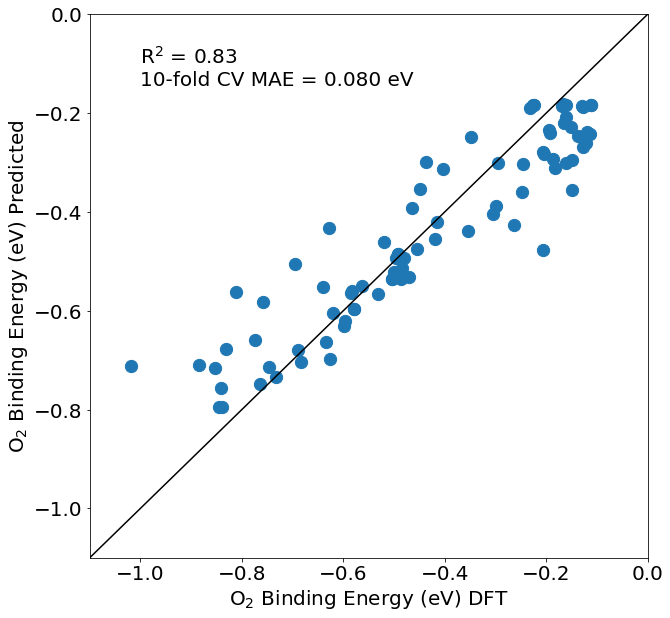

In [47]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.annotate("R$^2$ = 0.83", xy=(-1,-0.1))
ax.annotate("10-fold CV MAE = 0.080 eV", xy=(-1,-0.145))
plt.plot([-1.1,0],[-1.1,0.], color="black")
plt.ylim([-1.1,0])
plt.xlim([-1.1,0])
plt.ylabel(r"O$_2$ Binding Energy (eV) Predicted")
plt.xlabel(r"O$_2$ Binding Energy (eV) DFT")
plt.scatter(y_test_group, y_pred, s=150)
#plt.show()
plt.savefig("Regression_R2_MAE.png")

In [10]:
model.fit(X_train_group, y_train_group, epochs=200, batch_size=16, class_weight={0:4, 1:1})

Epoch 1/200
232/232 [==============================] - 1s 5ms/step - loss: 0.2670 - accuracy: 0.9399
Epoch 2/200
232/232 [==============================] - 1s 5ms/step - loss: 0.2339 - accuracy: 0.9393
Epoch 3/200
232/232 [==============================] - 1s 5ms/step - loss: 0.2156 - accuracy: 0.9436
Epoch 4/200
232/232 [==============================] - 1s 5ms/step - loss: 0.2140 - accuracy: 0.9458
Epoch 5/200
232/232 [==============================] - 1s 5ms/step - loss: 0.2178 - accuracy: 0.9469
Epoch 6/200
232/232 [==============================] - 1s 5ms/step - loss: 0.1966 - accuracy: 0.9498
Epoch 7/200
232/232 [==============================] - 1s 5ms/step - loss: 0.2092 - accuracy: 0.9412
Epoch 8/200
232/232 [==============================] - 1s 5ms/step - loss: 0.2163 - accuracy: 0.9417
Epoch 9/200
232/232 [==============================] - 1s 5ms/step - loss: 0.2118 - accuracy: 0.9428
Epoch 10/200
232/232 [==============================] - 1s 5ms/step - loss: 0.2027 - accura

232/232 [==============================] - 1s 5ms/step - loss: 0.1718 - accuracy: 0.9569
Epoch 161/200
232/232 [==============================] - 1s 5ms/step - loss: 0.1736 - accuracy: 0.9555
Epoch 162/200
232/232 [==============================] - 1s 5ms/step - loss: 0.1632 - accuracy: 0.9550
Epoch 163/200
232/232 [==============================] - 1s 5ms/step - loss: 0.1958 - accuracy: 0.9536
Epoch 164/200
232/232 [==============================] - 1s 5ms/step - loss: 0.1718 - accuracy: 0.9579
Epoch 165/200
232/232 [==============================] - 1s 5ms/step - loss: 0.1802 - accuracy: 0.9531
Epoch 166/200
232/232 [==============================] - 1s 5ms/step - loss: 0.1660 - accuracy: 0.9555
Epoch 167/200
232/232 [==============================] - 1s 5ms/step - loss: 0.1788 - accuracy: 0.9536
Epoch 168/200
232/232 [==============================] - 1s 5ms/step - loss: 0.1722 - accuracy: 0.9558
Epoch 169/200
232/232 [==============================] - 1s 5ms/step - loss: 0.1704 - a

In [11]:
_, accuracy = model.evaluate(X_test_group, y_test_group)
print('Accuracy: %.2f' % (accuracy*100))

14/14 [==============================] - 0s 2ms/step - loss: 0.2229 - accuracy: 0.9538
Accuracy: 95.38
